In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping,TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta
import os
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Import clean training and testing sets from [here](https://drive.google.com/drive/folders/1dpQesDFilx-QjGvFxFRcCkGwv5JJcjN_?usp=sharing) 

In [2]:
#image generator 

def imagegen(train_path,valid_path,test_path,batch_size):
    
    
    '''
    Image generator function 
    
    Parameters:
    train_path - path to the training data set
    valid_path - path to the validation data set
    test_path - path to the test data set
    batch_size - batch size 
    
    
    return: (train_generator, validation_generator, testing_generator)  
    - training image generator, validation image generator, testing image generator 
    
    '''

    #training images augumentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,validation_split=0.2)

    # validation augumentation 
    #valid_datagen = ImageDataGenerator(rescale=1./255)# only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)# only rescaling
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            train_path,  # this is the target directory
            target_size=image_size,  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',subset='training')  # since categorical_crossentropy loss is used, we need binary labels

    # this is a similar generator, for validation data
    '''validation_generator = valid_datagen.flow_from_directory(
            valid_path,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical')'''
    validation_generator = train_datagen.flow_from_directory(
            train_path,  # this is the target directory
            target_size=image_size,  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',subset='validation')
    
    testing_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=image_size,
            batch_size=batch_size,
            shuffle = False,
            class_mode='categorical')
    return train_generator, validation_generator, testing_generator

In [3]:
# training model 

def fit(model, model_name, image_generator, batch_size, epochs, no_train_img, no_valid_img):
    
    '''
    training function to rain CNN model 
    
    Parameters:
    
    model - CNN model
    model_name - model name to save data 
    image_generator - generator to generate train/validation images
    batch_size - batch size
    epochs - number of epochs 
    no_train_img - number of training images
    no_valid_img - number of validation images
    '''
    
    
    
    #tensorboary
    print(model.summary())
    tbc = TensorBoard(log_dir='/output/{}'.format(model_name), histogram_freq=0, write_graph=True, write_images=True)
    
    history =model.fit_generator(
        image_generator[0],
        steps_per_epoch=no_train_img // batch_size,
        epochs=epochs,
        validation_data=image_generator[1],
        validation_steps=no_valid_img // batch_size,callbacks=[tbc]  )
    
    #save
    model.save('{}.h5'.format(model_name)) 
    model.save_weights('{}_weights.h5'.format(model_name)) 
    
    #plot
    
    # Loss Curves
    plt.figure(figsize=[8,6]);
    plt.plot(history.history['loss'],'r',linewidth=3.0);
    plt.plot(history.history['val_loss'],'b',linewidth=3.0);
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Loss',fontsize=16);
    plt.title('Loss Curves {}'.format(model_name),fontsize=16);
   

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0);
    plt.plot(history.history['val_acc'],'b',linewidth=3.0);
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Accuracy',fontsize=16);
    plt.title('Accuracy Curves {}'.format(model_name),fontsize=16);
   

    print(history.history['val_acc'][-1])

    

In [11]:
# testing model 
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report


#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='cividis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#test function
    
def predict(model,model_name,image_generator,no_images,batch_size):
    
    '''
    Test function to test the CNN model 
    
    
    model - CNN model
    model_name - model name to save data 
    image_generator - image generator to generate test images
    batch_size = batch size 
    
    
    
    '''
    dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
    steps=no_images/batch_size
    predictions = model.predict_generator(image_generator[2])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = image_generator[2].classes
    class_labels = list(image_generator[2].class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)  
    cm =confusion_matrix(true_classes, predicted_classes)
    cm_plot_labels = list(image_generator[2].class_indices.keys()) 
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix {}'.format(model_name))
    
    

In [12]:
%ls /data/

TEST/  TRAIN/


In [ ]:
#parameters
batch_size = 32
image_size = (80, 60)
input_shape = (80, 60,3)
epochs = 15

#specify paths for train and test sets
train_path = '/data/TRAIN'
test_path = '/data/TEST'

if not os.path.exists(train_path):
    raise Exception('No train folder found')

if not os.path.exists(test_path):
    raise Exception('No test folder found')


In [14]:
image_generator=imagegen(train_path,valid_path,test_path,batch_size)


Found 6852 images belonging to 4 classes.
Found 1711 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.


In [10]:
# example
model_name = 'Model_0'
#model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

In [ ]:
#fit(model, model_name, image_generator, batch_size, epochs, 7000, 1700)

In [ ]:
#predict(model ,'model',image_generator,2441,batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7488)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               958592    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total para

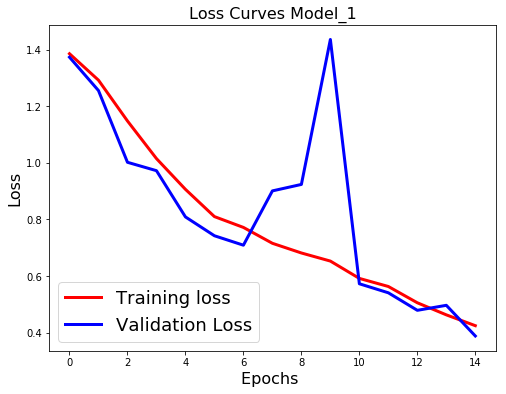

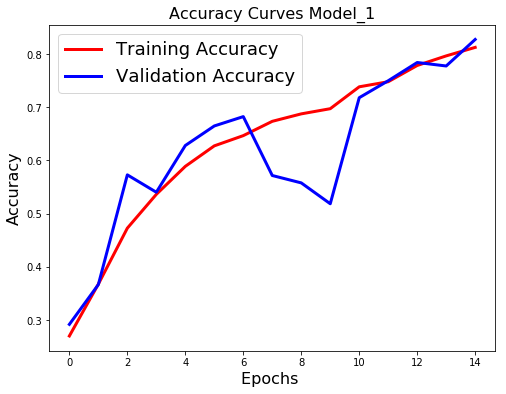

In [9]:
#model 1
model_name = 'Model_1'
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))
model1.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model1, model_name, image_generator, batch_size, epochs, 9957, 2487)


             precision    recall  f1-score   support

 EOSINOPHIL       0.78      0.72      0.75       617
 LYMPHOCYTE       0.99      0.92      0.96       599
   MONOCYTE       0.96      0.86      0.90       621
 NEUTROPHIL       0.68      0.85      0.75       604

avg / total       0.85      0.84      0.84      2441

Confusion matrix, without normalization
[[446   3   5 163]
 [ 30 552  17   0]
 [  8   0 532  81]
 [ 88   2   2 512]]


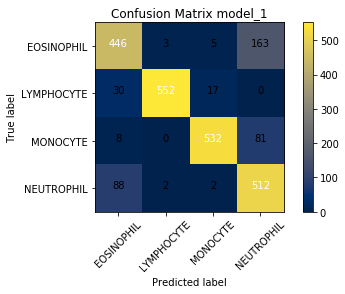

In [12]:
predict(model1 ,'model_1',image_generator,2487,batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2560)              0         
__________

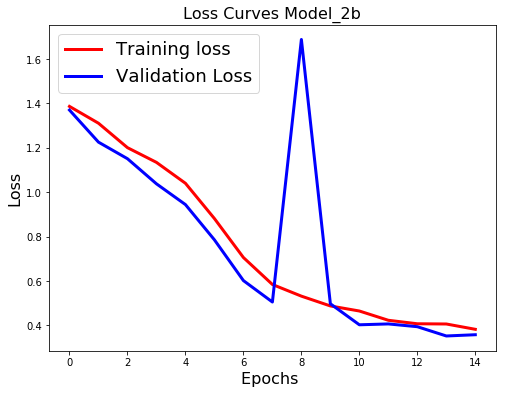

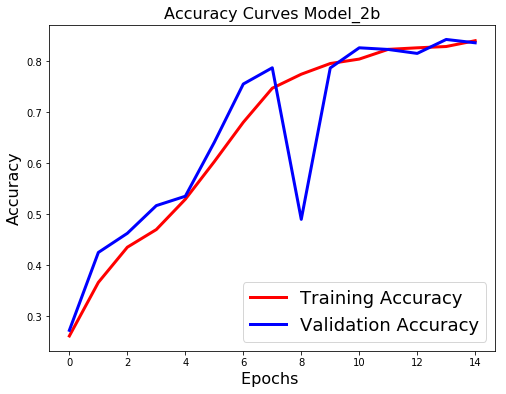

In [18]:
#model 2
model_name = 'Model_2b'
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model2, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.89      0.72      0.79       617
 LYMPHOCYTE       0.98      0.91      0.95       599
   MONOCYTE       0.95      0.95      0.95       621
 NEUTROPHIL       0.69      0.88      0.78       604

avg / total       0.88      0.86      0.87      2441

Confusion matrix, without normalization
[[443   5   4 165]
 [  2 546  11  40]
 [  2   1 589  29]
 [ 52   3  18 531]]


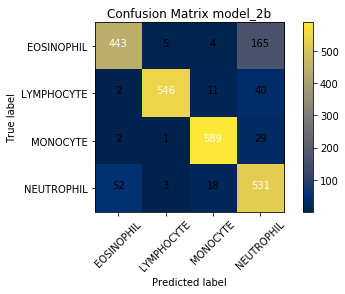

In [19]:
predict(model2 ,'model_2b',image_generator,2487,batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 3, 64)          36928     
__________

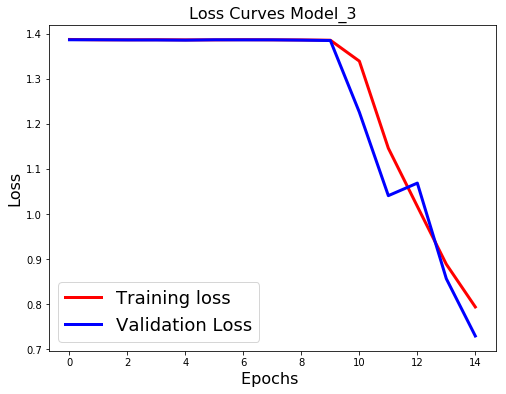

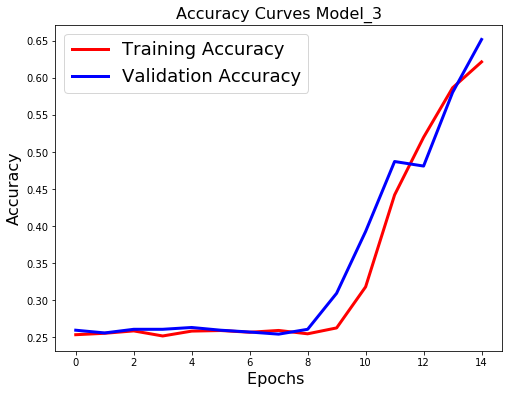

In [20]:
#model 3
model_name = 'Model_3'
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(4, activation='softmax'))
model3.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model3, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.59      0.27      0.37       617
 LYMPHOCYTE       0.92      0.81      0.86       599
   MONOCYTE       0.81      0.84      0.83       621
 NEUTROPHIL       0.43      0.72      0.54       604

avg / total       0.69      0.66      0.65      2441

Confusion matrix, without normalization
[[164  26  55 372]
 [ 10 484   4 101]
 [  9   0 520  92]
 [ 97  15  60 432]]


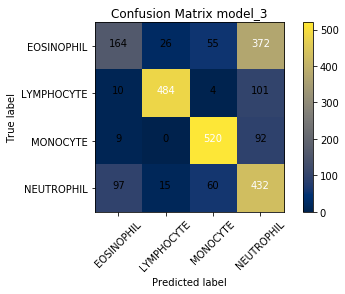

In [21]:
predict(model3 ,'model_3',image_generator,2487,batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2560)              0         
__________

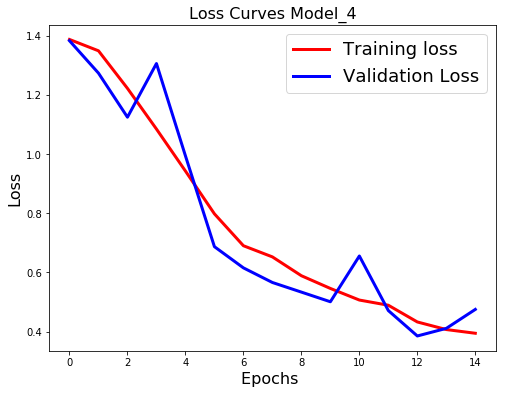

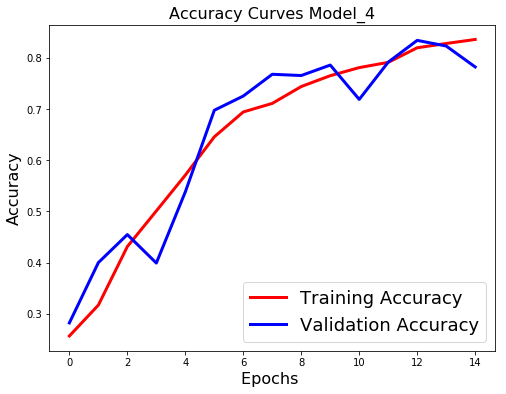

In [22]:
#model 4
model_name = 'Model_4'
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
#add extra Dense layer
model4.add(Dense(128, activation='relu'))
model4.add(Dense(4, activation='softmax'))
model4.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model4, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.60      0.92      0.73       617
 LYMPHOCYTE       0.92      0.97      0.94       599
   MONOCYTE       0.97      0.87      0.92       621
 NEUTROPHIL       0.87      0.44      0.58       604

avg / total       0.84      0.80      0.79      2441

Confusion matrix, without normalization
[[569  26   4  18]
 [ 15 583   0   1]
 [ 50   8 542  21]
 [307  18  13 266]]


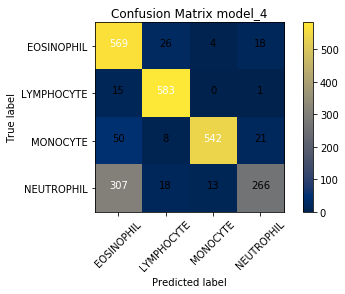

In [23]:
predict(model4 ,'model_4',image_generator,2487,batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2560)              0         
__________

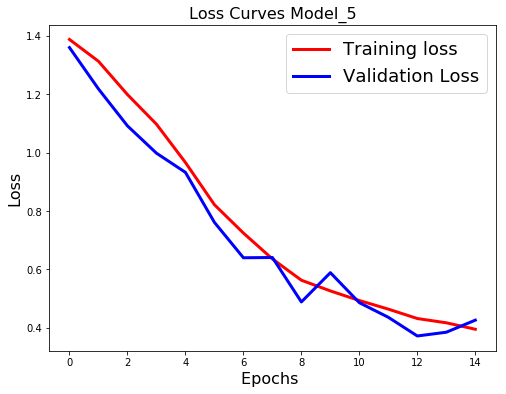

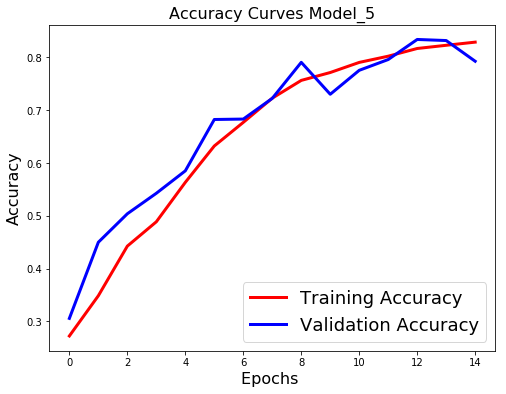

In [12]:
#model 5
model_name = 'Model_5'
model5 = Sequential()
model5.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model5.add(MaxPooling2D(pool_size=(2, 2)))


model5.add(Conv2D(32, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))



model5.add(Flatten())
model5.add(Dense(128, activation='relu'))


#add dropout 
model5.add(Dropout(0.5))

model5.add(Dense(4, activation='softmax'))
model5.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model5, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.88      0.56      0.68       617
 LYMPHOCYTE       0.96      0.94      0.95       599
   MONOCYTE       0.95      0.91      0.93       621
 NEUTROPHIL       0.62      0.90      0.74       604

avg / total       0.85      0.83      0.82      2441

Confusion matrix, without normalization
[[345  11   6 255]
 [  5 564  10  20]
 [  4   1 563  53]
 [ 40   9  12 543]]


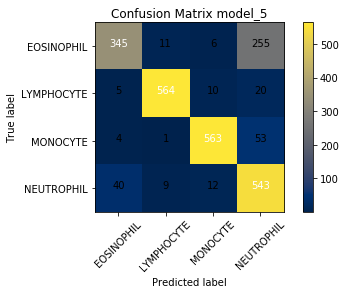

In [13]:
predict(model5 ,'model_5',image_generator,2487,batch_size = 1)

In [7]:
batch_size = 64
image_generator=imagegen(train_path,valid_path,test_path,batch_size)

Found 6852 images belonging to 4 classes.
Found 1711 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2560)              0         
__________

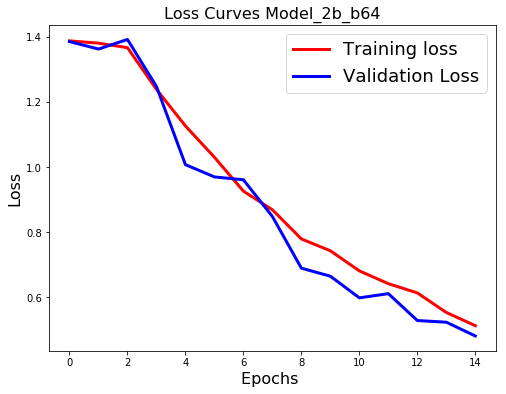

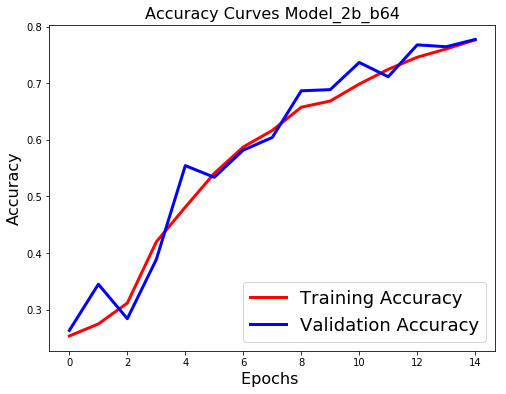

In [9]:
#model 2b batch = 64
model_name = 'Model_2b_b64'
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
fit(model2, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.65      0.83      0.73       617
 LYMPHOCYTE       0.96      0.92      0.94       599
   MONOCYTE       0.95      0.81      0.87       621
 NEUTROPHIL       0.65      0.59      0.62       604

avg / total       0.80      0.79      0.79      2441

Confusion matrix, without normalization
[[511  11   1  94]
 [ 15 549  15  20]
 [ 35   1 502  83]
 [226  10   9 359]]


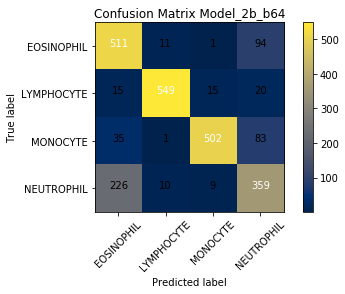

In [11]:
predict(model2 ,'Model_2b_b64',image_generator,2487,batch_size = 1)

In [12]:
batch_size = 16
image_generator=imagegen(train_path,valid_path,test_path,batch_size)

Found 6852 images belonging to 4 classes.
Found 1711 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2560)              0         
__________

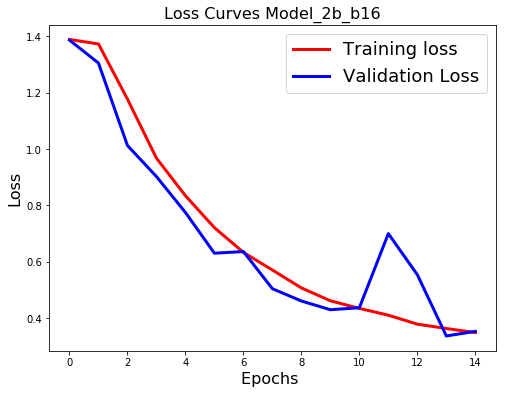

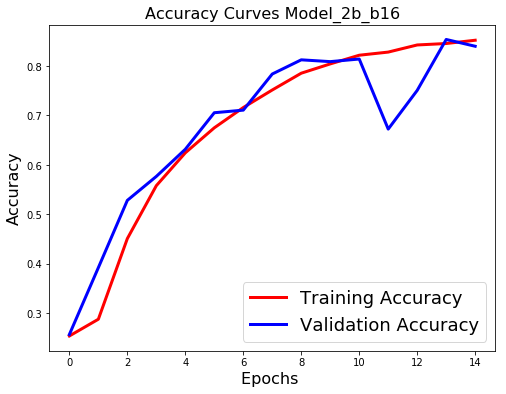

In [13]:
#model 2b batch = 16
model_name = 'Model_2b_b16'
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
fit(model2, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.89      0.65      0.75       617
 LYMPHOCYTE       0.98      0.91      0.94       599
   MONOCYTE       0.95      0.94      0.94       621
 NEUTROPHIL       0.66      0.90      0.76       604

avg / total       0.87      0.85      0.85      2441

Confusion matrix, without normalization
[[402  11  10 194]
 [  3 545   7  44]
 [  0   1 582  38]
 [ 47   0  12 545]]


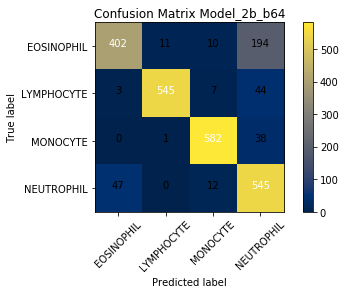

In [14]:
predict(model2 ,'Model_2b_b64',image_generator,2487,batch_size = 1)

In [7]:
batch_size = 32
image_generator=imagegen(train_path,valid_path,test_path,batch_size)

Found 6852 images belonging to 4 classes.
Found 1711 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2560)              0         
__________

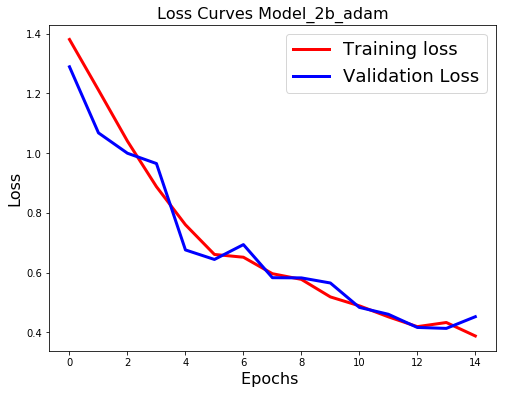

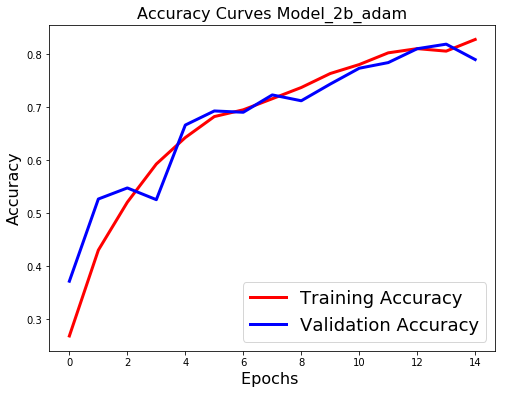

In [16]:
#model 2b optimizer = adam
model_name = 'Model_2b_adam'
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
fit(model2, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.73      0.61      0.66       617
 LYMPHOCYTE       0.99      0.90      0.94       599
   MONOCYTE       0.96      0.87      0.91       621
 NEUTROPHIL       0.60      0.80      0.68       604

avg / total       0.82      0.80      0.80      2441

Confusion matrix, without normalization
[[376   2   1 238]
 [  8 541  20  30]
 [ 21   0 542  58]
 [113   5   4 482]]


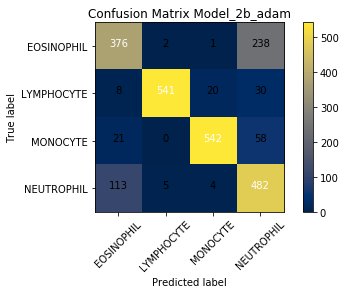

In [17]:
predict(model2 ,'Model_2b_adam',image_generator,2487,batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2560)              0         
__________

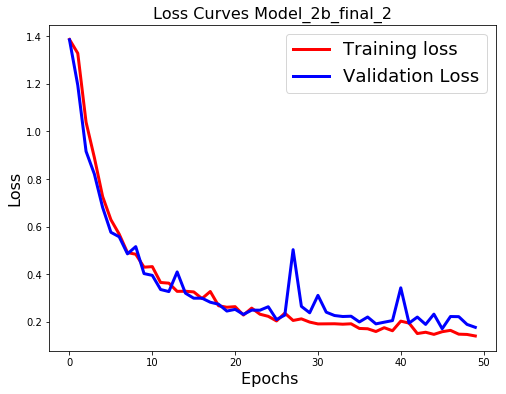

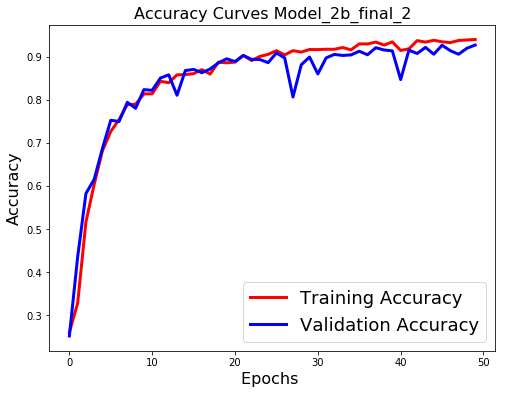

In [15]:
#model 2b optimizer = adam
epochs = 50
model_name = 'Model_2b_final_2'
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
fit(model2, model_name, image_generator, batch_size, epochs, 9957, 2487)

             precision    recall  f1-score   support

 EOSINOPHIL       0.89      0.87      0.88       617
 LYMPHOCYTE       0.98      0.98      0.98       599
   MONOCYTE       0.99      0.98      0.99       621
 NEUTROPHIL       0.85      0.88      0.87       604

avg / total       0.93      0.93      0.93      2441

Confusion matrix, without normalization
[[538   4   1  74]
 [  2 589   0   8]
 [  2   1 608  10]
 [ 62   6   4 532]]


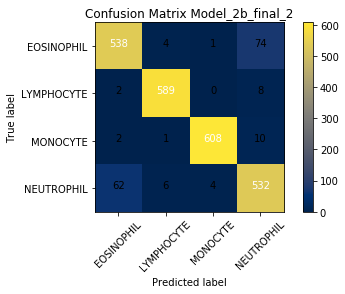

In [16]:
predict(model2 ,'Model_2b_final_2',image_generator,2487,batch_size = 1)